In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid")

depo_order = ["Tidal Channel", "Flood Tidal Delta", "Shoreface"]
RESULT_DIR = "../results/"

# Interwell distances

In [8]:
idx = pd.IndexSlice


def injector_producer_unitarrows(locations, injectors, producers):
    out = pd.DataFrame(
        index=pd.MultiIndex.from_product([injectors, producers]),
        columns=["angle", "xn", "yn"],
    )
    for i, p in out.index:
        x1, y1 = locations.loc[i, ["SURFX ft", "SURFY ft"]]
        x2, y2 = locations.loc[p, ["SURFX ft", "SURFY ft"]]
        out.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
    out["xn"] = out["angle"].map(np.sin)
    out["yn"] = out["angle"].map(np.cos)
    return out


def arrows(gains_spatial, locations, arrow_factor=1):
    to_join = pd.DataFrame(
        index=gains_spatial.index.drop_duplicates(),
        columns=["angle", "dist", "xn", "yn"],
        dtype="float",
    )
    for i, p in to_join.index:
        x1, y1 = locations.loc[i, ["SURFX ft", "SURFY ft"]]
        x2, y2 = locations.loc[p, ["SURFX ft", "SURFY ft"]]
        to_join.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
        to_join.loc[idx[i, p], "dist"] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    to_join["xn"] = to_join["angle"].map(np.sin)
    to_join["yn"] = to_join["angle"].map(np.cos)
    new_gains_df = gains_spatial.join(to_join)
    for axis in ["x", "y"]:
        new_gains_df[axis + "_arrow"] = (
            new_gains_df[axis + "n"] * new_gains_df["Gain"] * arrow_factor
        )
    return new_gains_df.drop(columns=["xn", "yn"])


def angle(x1, x2, y1, y2):
    x_diff = x2 - x1
    y_diff = y2 - y1
    return np.arctan2(x_diff, y_diff)


# gains_df = arrows(gains_spatial, locations, arrow_factor=1)

In [9]:
locations = pd.read_csv(
    "../data/well_locations_Senlac.csv",
    skiprows=[0, 1],
    names=["Well ID", "SURFX ft", "SURFY ft"],
    index_col=0,
)
locations["Type"] = locations.index.map(
    lambda x: "Producer" if x[0] == "P" else "Injector"
)

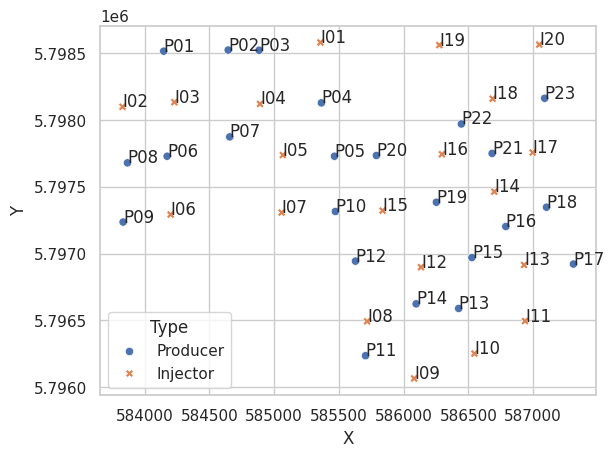

In [10]:
g = sns.scatterplot(
    data=locations, x="SURFX ft", y="SURFY ft", style="Type", hue="Type"
)
g.set(xlabel="X", ylabel="Y")
for i in range(locations.shape[0]):
    g.annotate(
        locations.index[i],
        (locations["SURFX ft"].iloc[i], locations["SURFY ft"].iloc[i]),
    )

In [11]:
# connectivity, Jerry's distances
excel = pd.ExcelFile("../results_Jerry/Lambda vs IWD all wells Frank.xlsx")
df = pd.concat(
    [
        pd.read_excel(excel, sheet_name=s)
        .dropna(how="all")
        .assign(
            Deposition=s.replace(" OK", ""),
            Injector=lambda x: x.Injector.fillna(method="ffill"),
        )
        .rename(columns={"Lambda": "Gain"})
        for s in excel.sheet_names
    ]
).dropna(axis="columns")
producers = df.Producer.unique()
injectors = df.Injector.unique()
df = df.set_index(["Injector", "Producer"])

# distances from locations
df = arrows(df, locations)

# azimuths from Jerry
excel = pd.ExcelFile("../results_Jerry/Lambda and Azimuth for Frank.xlsx")
df2 = pd.concat(
    [
        pd.read_excel(excel, sheet_name=s)
        .dropna(how="all")
        .assign(
            Deposition=s.replace(" OK", ""),
            Producer=lambda x: x.Producer.fillna(method="ffill"),
        )
        .drop(columns=["Unnamed: 4"])
        for s in excel.sheet_names
    ]
).dropna(axis="columns")
df2["Azimuth bin"] = pd.cut(
    df2["Azimuth mod 180"],
    range(15, 196, 30),
).fillna(
    pd.Interval(165, 195, closed="right")
)  # labels=['<45', '45-90', '90-135','>135'])
df2["Fraction of wells"] = df2["Connectivity"].apply(lambda x: 1 if x > 0.05 else 0)
print(df.shape)
df = df.merge(
    df2[
        ["Injector", "Producer", "Azimuth mod 180", "Azimuth bin", "Fraction of wells"]
    ],
    on=["Injector", "Producer"],
    how="left",
)  # .dropna('columns', how='all')
df.drop(columns=["Azimuth bin"]).to_feather("../data/gain_distance.feather")
df

mpi_data = pd.read_parquet(RESULT_DIR + "Lambda_MPI.parquet")
crm_gains_new = pd.read_csv(RESULT_DIR + "Senlac_CRM_jax_gains.csv", index_col=0)

df = df.merge(
    -mpi_data.rename_axis(index="Producer", columns="Injector")
    .stack()
    .rename("Gain_MPI"),
    left_on=["Producer", "Injector"],
    right_index=True,
).merge(
    crm_gains_new.rename_axis(index="Producer", columns="Injector")
    .stack()
    .rename("Gain_CRM_Frank"),
    left_on=["Producer", "Injector"],
    right_index=True,
)

(239, 8)


/tmp/ipykernel_433084/2105451076.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Injector=lambda x: x.Injector.fillna(method="ffill"),
/tmp/ipykernel_433084/2105451076.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Injector=lambda x: x.Injector.fillna(method="ffill"),
/tmp/ipykernel_433084/2105451076.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Injector=lambda x: x.Injector.fillna(method="ffill"),
/tmp/ipykernel_433084/2105451076.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Producer=lambda x: x.Producer.fillna(method="ffill"),
/tmp/ipykernel_433084/2105451076.py:30: FutureWarning: Series.fillna with 'method' is d

[Text(0.5, 0, 'Distance from spreadsheet'),
 Text(0, 0.5, 'Distance from locations')]

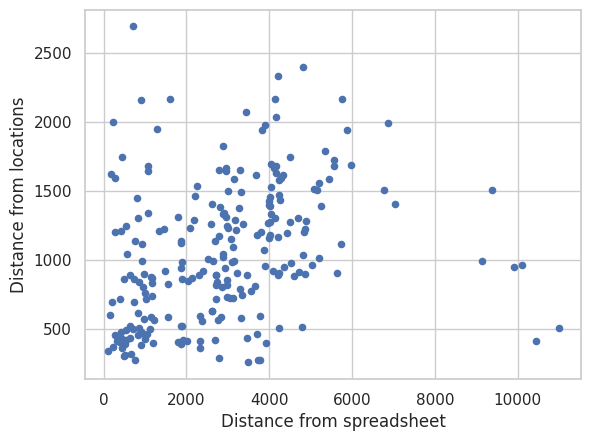

In [12]:
df.plot.scatter(x="Interwell Distance (m)", y="dist")
plt.gca().set(xlabel="Distance from spreadsheet", ylabel="Distance from locations")

[Text(0.5, 0, 'Angle from spreadsheet'), Text(0, 0.5, 'Angle from locations')]

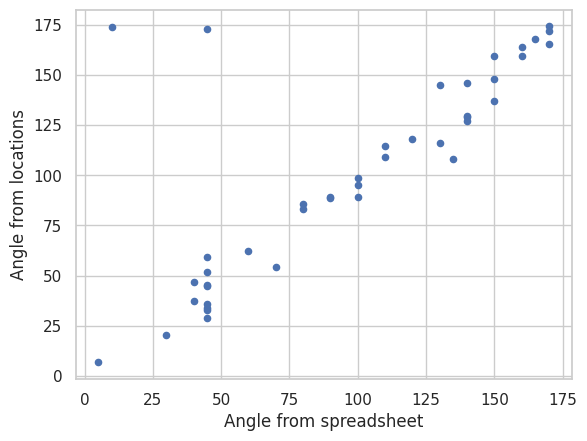

In [13]:
df.assign(angle2=lambda x: np.mod(x.angle * 180 / np.pi + 360, 180)).plot.scatter(
    x="Azimuth mod 180", y="angle2"
)
plt.gca().set(xlabel="Angle from spreadsheet", ylabel="Angle from locations")

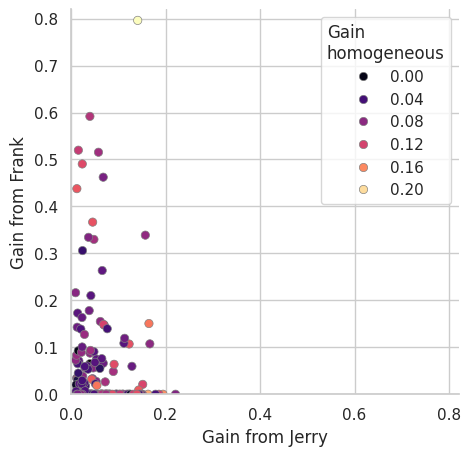

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.scatterplot(
    data=df.rename(columns={"Gain_MPI": "Gain\nhomogeneous"}),
    x="Gain",
    y="Gain_CRM_Frank",
    hue="Gain\nhomogeneous",
    palette="magma",
    edgecolor="gray",
    ax=ax,
)
g.set(
    xlabel="Gain from Jerry", ylabel="Gain from Frank", xlim=(0, 0.82), ylim=(0, 0.82)
)
sns.despine()

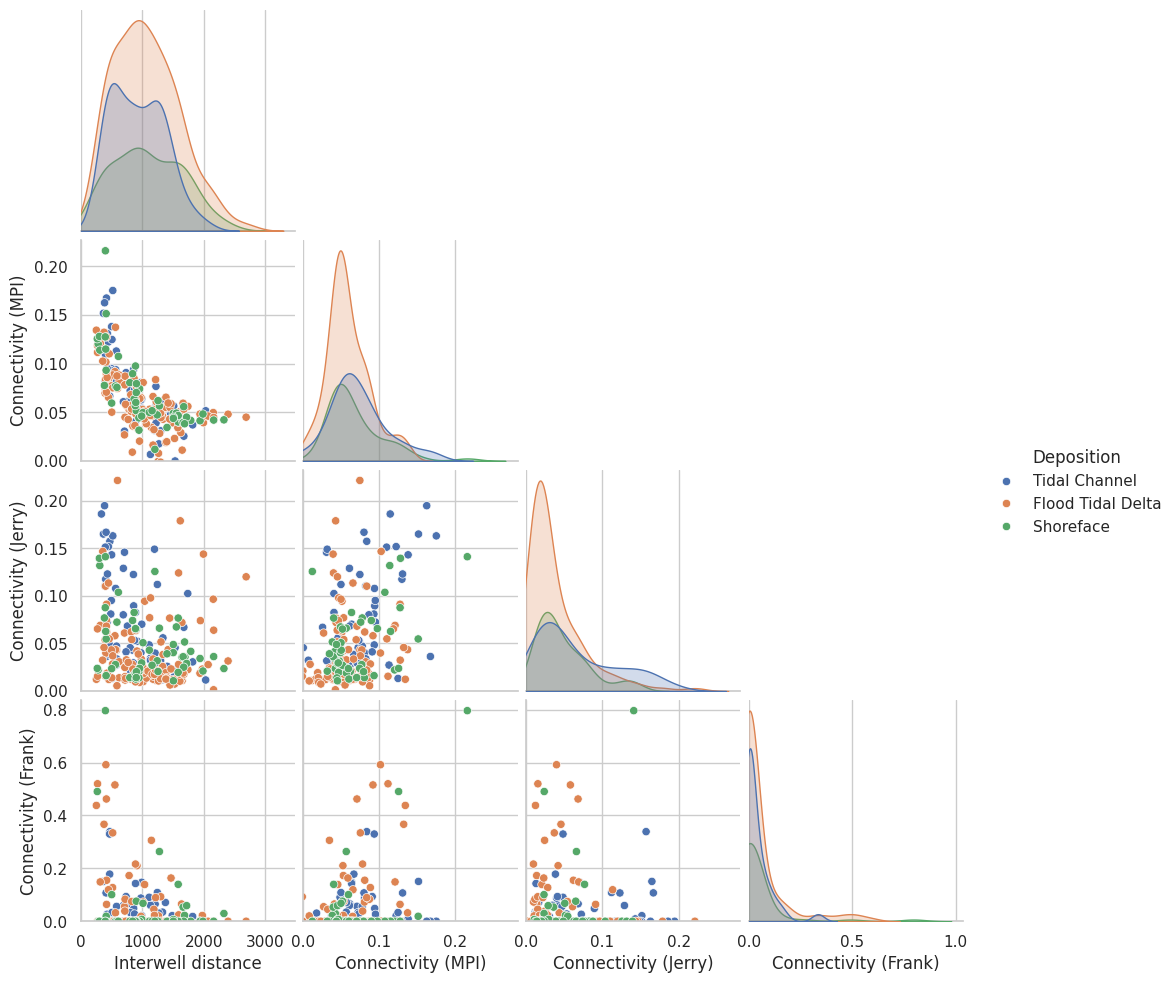

In [16]:
data = df[["dist", "Gain_MPI", "Gain", "Gain_CRM_Frank", "Deposition"]].rename(
    columns={
        "Gain": "Connectivity (Jerry)",
        "Gain_CRM_Frank": "Connectivity (Frank)",
        "Gain_MPI": "Connectivity (MPI)",
        "dist": "Interwell distance",
    }
)

g = sns.pairplot(data, hue="Deposition", corner=True)
g.set(xlim=(0, None), ylim=(0, None))
g.savefig("figures/gain_comparison.png")

# data.corr()**2

/home/frank/Dropbox/ROZ/Senlac/.venv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/frank/Dropbox/ROZ/Senlac/.venv/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


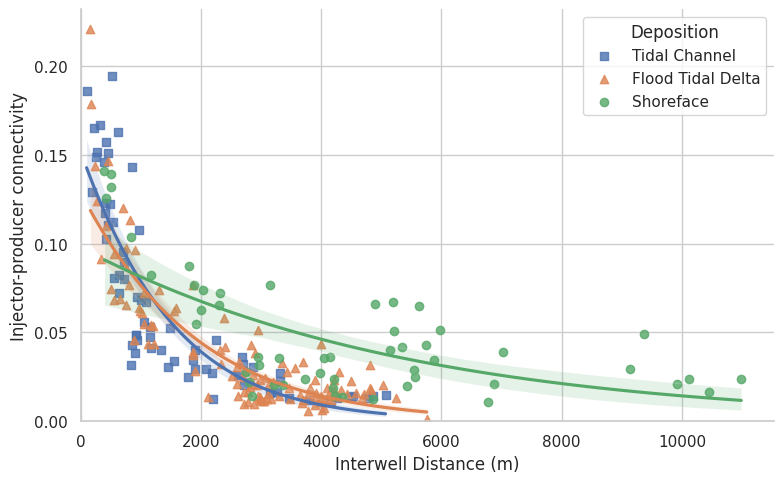

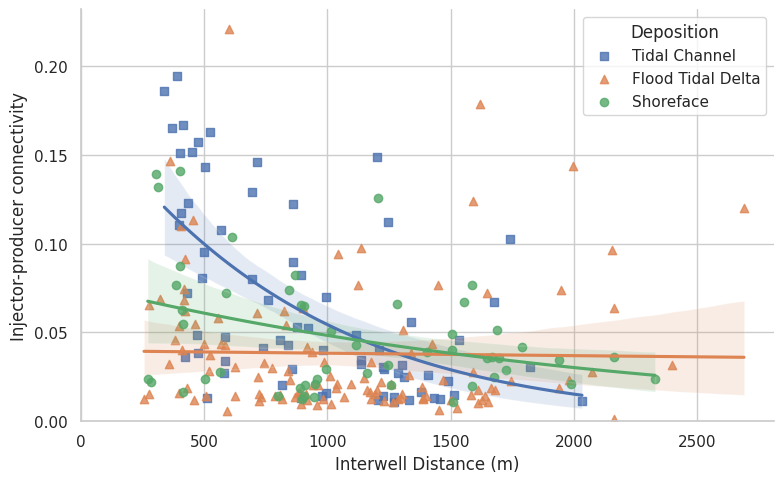

In [17]:
# plotting simplicity

facet = sns.lmplot(
    data=df,
    x="Interwell Distance (m)",
    y="Gain",
    hue="Deposition",
    hue_order=depo_order,
    markers=["s", "^", "o"],
    logistic=True,
    legend_out=False,
    aspect=1.6,
)
facet.set(xlim=(0, None), ylabel="Injector-producer connectivity", ylim=(0, None))
# facet.savefig('figures/per-depo-connectivity.png', dpi=300, bbox_inches='tight')

facet = sns.lmplot(
    data=df,
    x="dist",
    y="Gain",
    hue="Deposition",
    hue_order=depo_order,
    markers=["s", "^", "o"],
    logistic=True,
    legend_out=False,
    aspect=1.6,
)
facet.set(
    xlabel="Interwell Distance (m)",
    xlim=(0, None),
    ylabel="Injector-producer connectivity",
    ylim=(0, None),
)
facet.savefig("figures/per-depo-connectivity.png", dpi=300, bbox_inches="tight")

# Azimuth

[(0.0, 1.05), Text(0, 0.5, 'Fraction of wells connected')]

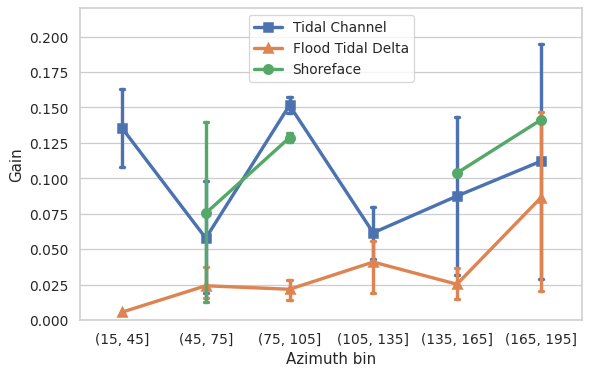

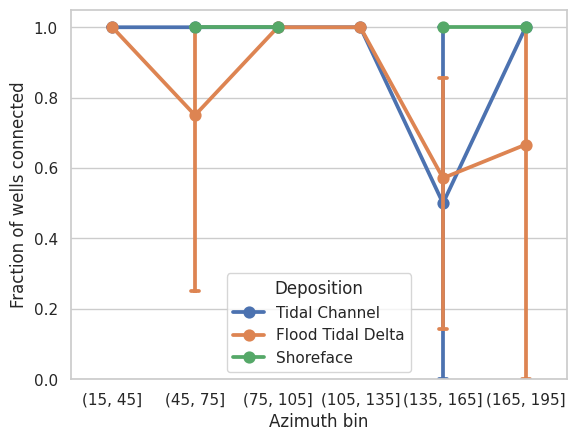

In [19]:
fig, ax = plt.subplots(figsize=(4.5 * 1.6, 4.5), dpi=90)
g = sns.pointplot(
    x="Azimuth bin",
    y="Gain",
    hue="Deposition",
    data=df,
    capsize=0.05,
    ax=ax,
    markers=["s", "^", "o"],
    hue_order=depo_order,
)
g.set(ylim=(0, 0.22))
g.legend(loc="upper center")
fig.savefig("figures/azimuth-depo-connectivity.png", dpi=400, bbox_inches="tight")

plt.figure()
g2 = sns.pointplot(
    x="Azimuth bin",
    y="Fraction of wells",
    hue="Deposition",
    data=df,
    capsize=0.1,
)
g2.set(ylim=(0, None), ylabel="Fraction of wells connected")